# MNIST - Handwriting Recognition

In [21]:
from com.yahoo.ml.caffe.DisplayUtils import *
from com.yahoo.ml.caffe.CaffeOnSpark import *
from com.yahoo.ml.caffe.Config import *
from com.yahoo.ml.caffe.DataSource import *

## Training Data

In [22]:
df = sqlCtx.read.parquet('/Users/afeng/dev/ml/CaffeOnSpark/data/mnist_test_dataframe')

In [23]:
show_df(df,5)

Index,Label,Image
00000000,7,
00000001,2,
00000002,1,
00000003,0,
00000004,4,


# Training

In [24]:
cos=CaffeOnSpark(sc)

In [25]:
args={}
args['conf']='/Users/afeng/dev/ml/CaffeOnSpark/data/lenet_dataframe_solver.prototxt'
args['model']='file:///tmp/lenet.model'
args['devices']='1'
args['clusterSize']='1'
cfg=Config(sc,args)

In [26]:
dl_train_source = DataSource(sc).getSource(cfg,True)
dl_validation_source = DataSource(sc).getSource(cfg,False)

In [27]:
cos.train(dl_train_source)

In [35]:
validation_result_df = cos.trainWithValidation(dl_train_source, dl_validation_source)

In [36]:
validation_result_df.show(10)

+----------+------------+
|  accuracy|        loss|
+----------+------------+
|   [0.875]| [0.3471902]|
| [0.84375]| [0.4911137]|
|[0.953125]|[0.23459314]|
|[0.859375]| [0.3887323]|
|[0.890625]| [0.4266619]|
|   [0.875]|[0.46928063]|
| [0.90625]| [0.3401285]|
| [0.78125]|  [0.685825]|
|[0.796875]|[0.60101354]|
|[0.859375]| [0.4460407]|
+----------+------------+
only showing top 10 rows



In [37]:
%matplotlib notebook
from matplotlib import pyplot as plt

<IPython.core.display.Javascript object>


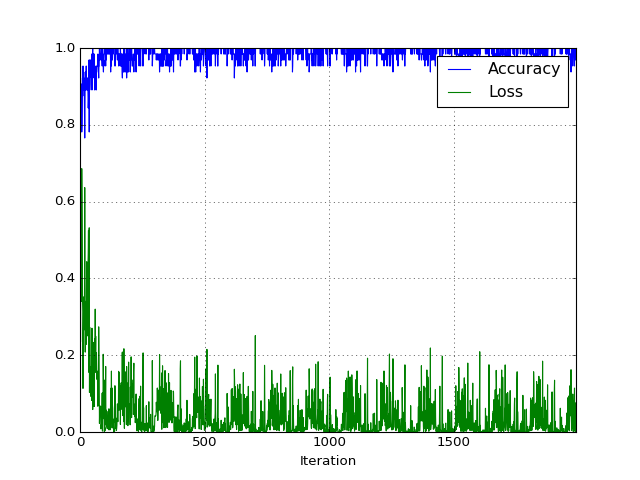

In [53]:
validation_panda_df = validation_result_df.toPandas()
validation_panda_df.accuracy.apply(lambda x: x[0]).plot()
validation_panda_df.loss.apply(lambda x: x[0]).plot()
plt.grid()
plt.xlabel('Iteration')
plt.legend(('Accuracy', 'Loss'))

# Test

In [39]:
dl_test_source = DataSource(sc).getSource(cfg,False)

In [40]:
test_result=cos.test(dl_test_source)

In [41]:
test_result

{u'accuracy': [0.9906850961538461], u'loss': [0.028188791983421443]}

# Feature Extraction

In [42]:
args['features']='accuracy,ip1,ip2'
args['label']='label'
cfg=Config(sc,args)

In [43]:
dl_feature_source = DataSource(sc).getSource(cfg,False)

In [44]:
f=cos.features(dl_feature_source)

In [45]:
f.show(5)

+--------+--------+--------------------+--------------------+-----+
|SampleID|accuracy|                 ip1|                 ip2|label|
+--------+--------+--------------------+--------------------+-----+
|00000000|   [1.0]|[-0.0, 2.1980903,...|[-3.4472382, 1.39...|[7.0]|
|00000001|   [1.0]|[3.3227508, -0.0,...|[2.1032064, 2.634...|[2.0]|
|00000002|   [1.0]|[0.48368892, 1.15...|[-2.0531938, 12.5...|[1.0]|
|00000003|   [1.0]|[-0.0, 2.1611724,...|[13.276651, -4.02...|[0.0]|
|00000004|   [1.0]|[-0.0, -0.0, 2.96...|[-2.0861607, -3.7...|[4.0]|
+--------+--------+--------------------+--------------------+-----+
only showing top 5 rows



In [46]:
def maxScoreAndIndex(array_of_scores): 
    return max(enumerate(array_of_scores), key=lambda x: x[1])
g = sqlContext.createDataFrame(f.map(lambda row: (
            row.SampleID,
            row.accuracy[0],
            row.ip2,
            maxScoreAndIndex(row.ip2)[1],
            maxScoreAndIndex(row.ip2)[0],
            int(row.label[0]))), 
            ["SampleID", "Accuracy", "Scores", "MaxScore", "Prediction", "Label"])
g.toPandas()[:5]

,SampleID,Accuracy,Scores,MaxScore,Prediction,Label
0,00000000,1.0,"[-3.44723820686, 1.3939551115, 1.61697733402, ...",19.351507,7,7
1,00000001,1.0,"[2.1032063961, 2.63455629349, 20.5081806183, -...",20.508181,2,2
2,00000002,1.0,"[-2.0531938076, 12.5048942566, 0.732997894287,...",12.504894,1,1
3,00000003,1.0,"[13.2766513824, -4.02789974213, 1.71845364571,...",13.276651,0,0
4,00000004,1.0,"[-2.08616065979, -3.76665687561, -3.8064892292...",15.448845,4,4


###  Logistic Regression using MLlib

In [47]:
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.classification import LogisticRegressionWithLBFGS

In [48]:
data = f.map(lambda row: LabeledPoint(row.label[0], Vectors.dense(row.ip1)))

In [49]:
lr = LogisticRegressionWithLBFGS.train(data, numClasses=10, iterations=10)

In [50]:
predictions = lr.predict(data.map(lambda pt : pt.features))

In [51]:
predictions.take(5)

[7, 2, 1, 0, 4]